# Interfacial Thermal Conductance (phonon only), for AMM and DMM models
Note: <br>
If $\Delta T \neq 0$:
$$\text{conductance} = \frac{\frac{1}{2\pi} \int_0^\infty \hbar \omega M(\omega) \mathcal{T}(\omega)
\left[f_{BE}(T_1) - f_{BE}(T_2) \right]\hspace{0.01in} \mathrm{d} \omega }{T_1 - T_2} $$
If $\Delta T = 0$:
$$\text{conductance} = \frac{1}{2\pi} \int_0^\infty \hbar \omega M(\omega) \mathcal{T}(\omega) \frac{\partial f_{BE}}{\partial T}\hspace{0.01in} \mathrm{d} \omega $$

In [1]:
## BEGIN INPUTS

dimensionality = 3 # number of dimensions
transmission_model = 'AMM' # 'AMM' or 'DMM'

# Assume that phonon moves from material 1 (where group velocity is v_1)
# towards material 2 (where group velocity is v_2). Note: must set v_1 >= v_2 for AMM model.
v_1 = 5000 # m/s, group velocity of material 1
v_2 = 1000 # m/s, group velocity of material 2

rho_1 = 0.05 # kg/m, linear mass density of material 1
rho_2 = 0.1 # kg/m, linear mass density of material 2

T_start = 50 # K, lowest temperature of the materials
T_end = 1000 # K, highest temperature of the materials
T_pts = 50 # number of temperature points to plot on each axis

## END INPUTS

In [2]:
# Run after running input cell
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

C_0 = 1/(2*np.pi)
hbar = 1.054 * 10**(-34) # J s
k_B = 1.38 * 10**(-23) # J/K

Z_1 = rho_1 * v_1
Z_2 = rho_2 * v_2

# Bose-Einstein distribution
f_BE = lambda T, omega: 1/(np.exp(hbar*omega/(k_B*T)) - 1)

# Derivative of Bose-Einstein distribution
df_BE_dt = lambda T, omega: (f_BE(T, omega))**2 * np.exp(hbar*omega/(k_B*T)) * hbar*omega/(k_B*T**2)

if dimensionality == 3:
    D = lambda omega, v_g: omega**2/(2 * np.pi**2 * v_g**3)
    M = lambda omega, v_g: omega**2/(4 * np.pi * v_g**2)
else:
    D = lambda omega, v_g: omega/(2 * np.pi * v_g**2)
    M = lambda omega, v_g: omega/(np.pi * v_g)
    
if transmission_model == 'AMM':
    T_integrand = lambda theta: (4*Z_2/Z_1 * (v_1**2 - (v_2*np.sin(theta))**2)**(1/2)/(v_1 * np.cos(theta)))\
                    /(Z_2/Z_1 + (v_1**2 - (v_2*np.sin(theta))**2)**(1/2)/(v_1 * np.cos(theta)))**2\
                    * np.cos(theta) * np.sin(theta)
    T_int = quad(T_integrand, 0, np.pi/2)[0]
    T = lambda omega: np.pi * v_1 * T_int * D(omega, v_1)
    Q_integrand = lambda omega, T_1, T_2: C_0 * \
                    hbar * omega * T(omega) * (f_BE(T_1, omega) - f_BE(T_2, omega))
    cond_integrand_deltaT_is_zero = lambda omega, T_1, T_2: C_0 * \
                                        hbar * omega * T(omega) * df_BE_dt(T_1, omega)
else:
    Q_integrand = lambda omega, T_1, T_2: C_0 * \
        hbar * omega * (M(omega, v_1) * M(omega, v_2))/(M(omega, v_1) + M(omega, v_2))\
        * (f_BE(T_1, omega) - f_BE(T_2, omega))
    cond_integrand_deltaT_is_zero = lambda omega, T_1, T_2: C_0 * \
        hbar * omega * (M(omega, v_1) * M(omega, v_2))/(M(omega, v_1) + M(omega, v_2))\
        * df_BE_dt(T_1, omega)

omega_trial_pts = 10

if dimensionality == 3: 
    omega_end_range = np.linspace(10**14, 10**17, omega_trial_pts)
else:
    omega_end_range = np.linspace(10**14, 10**16, omega_trial_pts)

def conductance(T_1, T_2):
    if T_1 == T_2:
        integrand = lambda omega, T_1, T_2: cond_integrand_deltaT_is_zero(omega, T_1, T_2)
    else:
        integrand = lambda omega, T_1, T_2: Q_integrand(omega, T_1, T_2)/(T_1 - T_2)
    conductance_trials = np.zeros(omega_trial_pts)
    for i in range(0, omega_trial_pts):
        conductance_trials[i] = quad(integrand, 1, omega_end_range[i], args=(T_1, T_2))[0]
    conductance_trials[~np.isfinite(conductance_trials)] = 0
    return np.amax(conductance_trials)

temp_linear = np.linspace(T_start, T_end, T_pts)
temp_2D = np.repeat(temp_linear[:, np.newaxis], T_pts, axis=1)
temp_2D_transposed = np.transpose(temp_2D)

conductance_arrayed = np.zeros((T_pts, T_pts))

for i in range(T_pts):
    for j in range(T_pts):
        conductance_arrayed[i,j] = conductance(temp_2D[i,j], temp_2D_transposed[i,j])

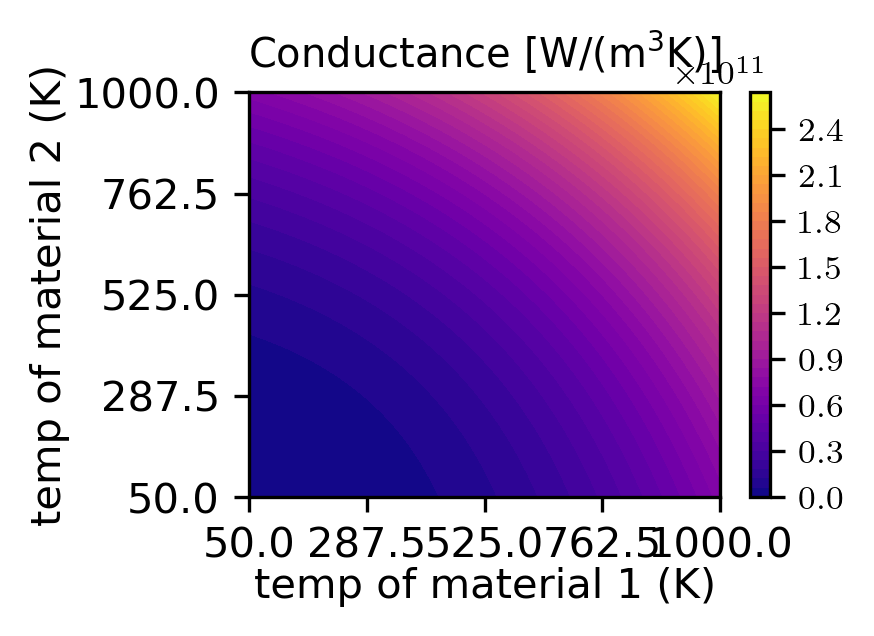

In [3]:
# Output cell
fig = plt.figure(figsize=(3, 2), dpi=300)
ax = plt.axes()
plt.plasma()

plt.rc('font', size=8)
plt.rc('text', usetex=True)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "stixsans"

if dimensionality == 3:
    plt.title('Conductance [W/($\mathrm{m}^3$K)]')
else:
    plt.title('Conductance [W/($\mathrm{m}^2$K)]')

ax.set_xlabel('temp of material 1 (K)')
ax.set_ylabel('temp of material 2 (K)')
num_tick_marks = 5
ax.set_xticks(np.linspace(T_start, T_end, num_tick_marks))
ax.set_yticks(np.linspace(T_start, T_end, num_tick_marks))

plt.tight_layout(pad=0.1, w_pad=0.1, h_pad=0.1)
ax.xaxis.labelpad = 0
ax.yaxis.labelpad = 1

c = ax.contourf(temp_2D, temp_2D_transposed, conductance_arrayed, 50)
fig.colorbar(c, ax=ax)
plt.show()